In [174]:
import scanpy as sc
import pandas as pd

import numpy as np
from scipy import stats

from matplotlib_venn import venn2
import matplotlib.pyplot as plt

import os
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
def load(path):
    adata = sc.read_h5ad(path)
    if 'Classification' in adata.obs.columns:
        adata.obs = adata.obs.rename(columns = {'Classification': 'adt'})

    adata.obs['adt'] = adata.obs['adt'] == 'Doublet'

    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in ['_scvi_batch', '_scvi_labels', 'solo_softmax_scores', 'solo_hard']]]

    return adata

In [41]:
methods = ['doubletdetection', 'scrublet', 'solo', 'scds', 'doubletFinder']

In [50]:
combinations = []
for r in range(1, len(methods) + 1):
    combinations.extend(itertools.combinations(methods, r))
combinations = [list(combo) for combo in combinations]

In [51]:
combinations

[['doubletdetection'],
 ['scrublet'],
 ['solo'],
 ['scds'],
 ['doubletFinder'],
 ['doubletdetection', 'scrublet'],
 ['doubletdetection', 'solo'],
 ['doubletdetection', 'scds'],
 ['doubletdetection', 'doubletFinder'],
 ['scrublet', 'solo'],
 ['scrublet', 'scds'],
 ['scrublet', 'doubletFinder'],
 ['solo', 'scds'],
 ['solo', 'doubletFinder'],
 ['scds', 'doubletFinder'],
 ['doubletdetection', 'scrublet', 'solo'],
 ['doubletdetection', 'scrublet', 'scds'],
 ['doubletdetection', 'scrublet', 'doubletFinder'],
 ['doubletdetection', 'solo', 'scds'],
 ['doubletdetection', 'solo', 'doubletFinder'],
 ['doubletdetection', 'scds', 'doubletFinder'],
 ['scrublet', 'solo', 'scds'],
 ['scrublet', 'solo', 'doubletFinder'],
 ['scrublet', 'scds', 'doubletFinder'],
 ['solo', 'scds', 'doubletFinder'],
 ['doubletdetection', 'scrublet', 'solo', 'scds'],
 ['doubletdetection', 'scrublet', 'solo', 'doubletFinder'],
 ['doubletdetection', 'scrublet', 'scds', 'doubletFinder'],
 ['doubletdetection', 'solo', 'scds', '

In [141]:
len(combinations)

31

In [101]:

def give_me_the_stats(true, predicted, bg):
    # True Positives (TP): Correctly predicted positives
    TP = len(true.intersection(predicted))
    # False Positives (FP): Predicted positives that are not actually positive
    FP = len(predicted - true)
    # False Negatives (FN): Actual positives that were not predicted as positive
    FN = len(true - predicted)
    # True Negatives (TN): Correctly predicted negatives
    TN = len(bg) - (TP + FP + FN)

    # Total Actual Positives (P) and Negatives (N)
    P = len(true)
    N = len(bg) - P

    # Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1 Score
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # False Positive Rate (FPR) and False Negative Rate (FNR)
    FPR = FP / N if N > 0 else 0
    FNR = FN / P if P > 0 else 0

    return [recall, FPR, FNR, f1]

    

def analyze_method(adata, methods):
    df =  adata.obs[['adt'] + methods].copy()
    df['Methods_count'] = df[methods].sum(axis = 1)
    df['Methods_union'] = df['Methods_count'] > 0
    df['Methods_intersect'] = df['Methods_count'] == len(methods)

    tp = set(df[df.adt].index)
    union = set(df[df.Methods_union].index)
    intersect = set(df[df.Methods_intersect].index)

    u_stats = give_me_the_stats(tp, union, df)
    i_stats = give_me_the_stats(tp, intersect, df)

    return ['_'.join(methods)] + u_stats + i_stats



In [ ]:
os.listdir

In [108]:
os.listdir('doublets_annotated/')

['D8_LNG_DOUBLETS.h5ad',
 'D2_LNG_DOUBLETS.h5ad',
 'Naive_RM_DOUBLETS.h5ad',
 'GSM3501447_cell_lines-ch_DOUBLETS.h5ad',
 'Naive_OM_DOUBLETS.h5ad',
 'PR8_C5_DOUBLETS.h5ad',
 'PR8_C2_DOUBLETS.h5ad',
 'GSE108313_pbmc-ch_DOUBLETS.h5ad',
 'D8_RM_DOUBLETS.h5ad',
 'D14_LNG_DOUBLETS.h5ad',
 'D8_OM_DOUBLETS.h5ad',
 'D2_RM_DOUBLETS.h5ad',
 'D14_RM_DOUBLETS.h5ad',
 'X31_D60_DOUBLETS.h5ad',
 'D2_OM_DOUBLETS.h5ad',
 'D5_RM_DOUBLETS.h5ad',
 'X31_C2_DOUBLETS.h5ad',
 'Naive_LNG_DOUBLETS.h5ad',
 'D14_OM_DOUBLETS.h5ad',
 'PR8_D60_DOUBLETS.h5ad',
 'GSE140262_mmkidney-ch_DOUBLETS.h5ad',
 'D5_LNG_DOUBLETS.h5ad',
 'X31_C5_DOUBLETS.h5ad']

In [112]:
adata = load('doublets_annotated/GSM3501447_cell_lines-ch_DOUBLETS.h5ad')

In [182]:
out = []
for path in [x for x in os.listdir('doublets_annotated/')]: # if x.startswith('GSE')
    adata = load('doublets_annotated/' + path)
    dataset = path.replace('.h5ad','')
    for method in combinations:
        out.append(analyze_method(adata, method) ) #+ [dataset]

In [183]:
res = pd.DataFrame(out, columns = ['methods', 'uRecal', 'uFPR', 'uFNR',
                                   'uF1', 'iRecal', 'iFPR', 'iFNR', 'iF1']) #'Dataset'

In [184]:
df = res.groupby('methods').mean()

In [191]:
df = df.sort_values('uRecal')

In [192]:
std = res.groupby('methods').std()

In [193]:
std = std.loc[df.index]

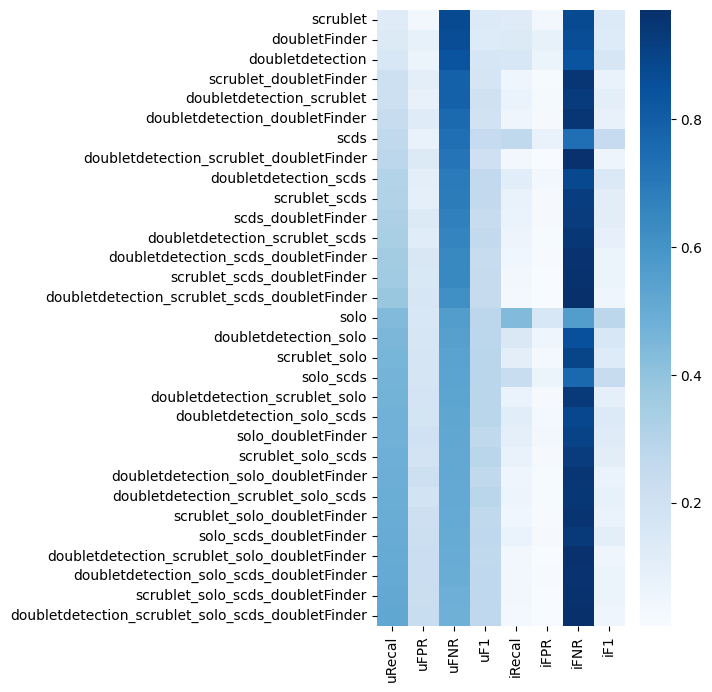

In [205]:
plt.figure(figsize = (4,8))
ax = sns.heatmap(df, cmap='Blues')
plt.ylabel('')

plt.savefig('STATS.png', dpi = 400, bbox_inches = 'tight')

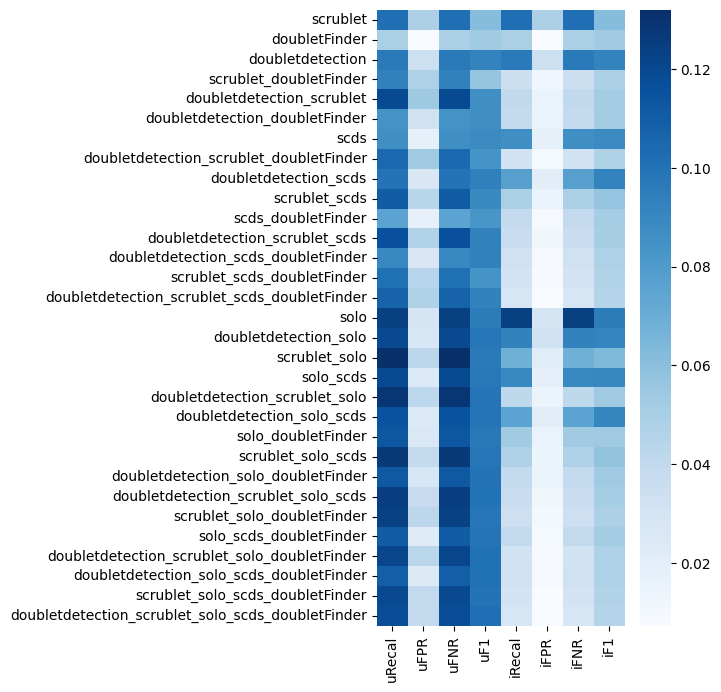

In [206]:
plt.figure(figsize = (4,8))
ax = sns.heatmap(std, cmap='Blues')
plt.ylabel('')

plt.savefig('STD.png', dpi = 400, bbox_inches = 'tight')